## **Download Packages**

In [2]:
!pip install patchify

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## **Loading Libraries**

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf
from tensorflow.keras.layers import Multiply,GlobalAveragePooling1D,MultiHeadAttention,Embedding,Lambda,Dense,Flatten,Conv2D,Dropout, Conv2DTranspose, MaxPooling2D, Input, Activation, Concatenate, UpSampling2D, Resizing,Reshape,Add,LayerNormalization,BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.colors as colors
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from patchify import patchify
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2


## **Load Data**

In [4]:
# Download the dataset from Kaggle
!kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies

# Unzip the downloaded dataset
!unzip -q "satellite-images-of-water-bodies.zip" -d "satellite-images-of-water-bodies"

Dataset URL: https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies
License(s): CC-BY-NC-SA-4.0
100%|████████████████████████████████████████| 247M/247M [00:07<00:00, 35.6MB/s]
100%|████████████████████████████████████████| 247M/247M [00:07<00:00, 36.5MB/s]


In [5]:
path = 'satellite-images-of-water-bodies/Water Bodies Dataset'

In [6]:
data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 6000, shuffle = False)

Found 5682 files belonging to 2 classes.


In [7]:
for images, masks in data:
    X = images.numpy().astype("uint8")
    y = masks.numpy().astype("uint8")

print(X.shape, y.shape)

(5682, 128, 128, 3) (5682,)


In [8]:
images = X[y == 0]
masks = X[y == 1]

print(images.shape, masks.shape)

(2841, 128, 128, 3) (2841, 128, 128, 3)


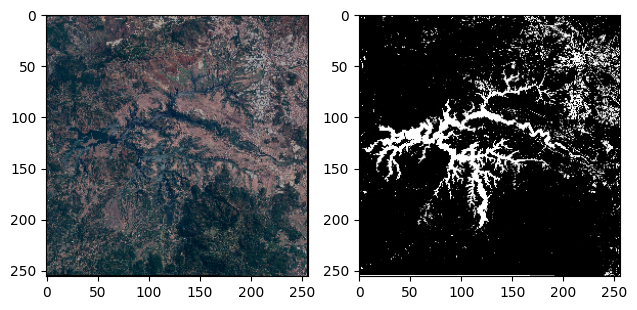

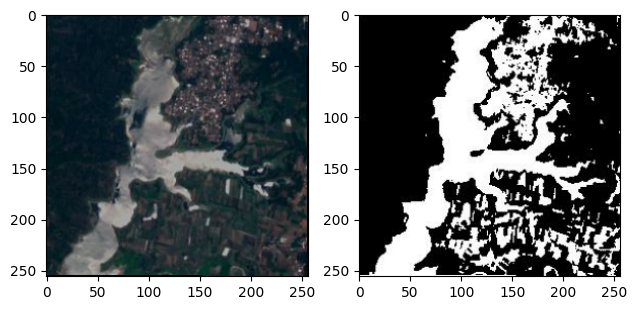

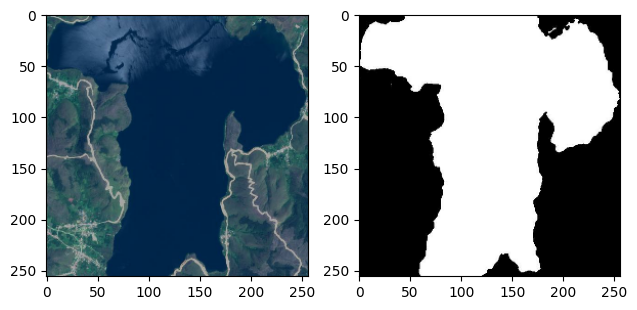

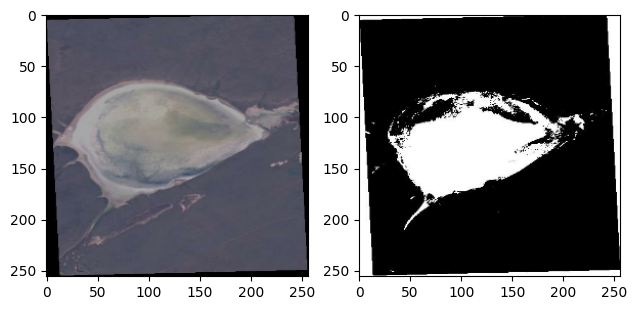

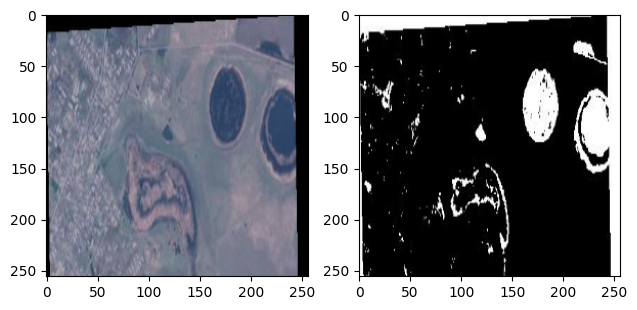

In [9]:
for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(images[i])

    plt.subplot(1, 2, 2)
    plt.imshow(masks[i])

    plt.tight_layout()
    plt.show()

## **Split Data into Train and Test**

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, masks, test_size = 0.2, random_state = 3)

print(X_train.shape, X_test.shape)

(2272, 128, 128, 3) (569, 128, 128, 3)


## **Mask to single Channel**

In [10]:
# Convert masks to single channel (binary)
y_train = (y_train[..., 0] > 0).astype("uint8")  # Assuming the first channel represents the mask
y_test = (y_test[..., 0] > 0).astype("uint8")

# Reshape your target arrays to match the model's output shape
y_train = y_train.reshape((-1, 128, 128, 1))
y_test = y_test.reshape((-1, 128, 128, 1))

print(y_train.shape, y_test.shape)

(2272, 128, 128, 1) (569, 128, 128, 1)


## **Function to plot metrics**

In [25]:
def plot_training_history(history, title):
    # Check if `history` is a dictionary and adapt
    if isinstance(history, dict):
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt


## **Early Stopping**

In [26]:
# Early Stopping
c1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)

## **Calculate IOU**

In [27]:
def calculate_IOU(y_true, y_pred, threshold = 0.5):
    y_pred = (y_pred > threshold).astype(np.uint8) # Binarize predictions
    intersection = np.sum(y_true * y_pred, axis = (1,2)) # Per image
    union = np.sum(y_true + y_pred, axis = (1,2)) - intersection # Per image
    iou = np.mean(intersection / (union + 1e-6)) # Avoid division by zero
    return iou

def Training_IoU(model, X_train, y_train):
    train_predictions = model.predict(X_train)
    train_predictions = train_predictions.squeeze()  # Shape:(height, width)
    y_train = y_train.squeeze()  # Shape:, height, width)

    train_iou = calculate_IOU(y_train, train_predictions)
    return train_iou

def Testing_IoU (model, X_test, y_test):
    test_predictions = model.predict(X_test)
    test_predictions = test_predictions.squeeze()  # Shape: ( height, width)
    y_test = y_test.squeeze()  # Shape: (batch_size, height, width)

    test_iou = calculate_IOU(y_test, test_predictions)
    return test_iou
    
    

## **Training history**
**IOU**

**Training and Validation Accuracy**

**Training and Validation Loss**

In [28]:
def trained_history(path, trained_model, algo, X_train, y_train, X_test, y_test):
  with open(path,'rb') as file:
    loaded_history = pickle.load(file)
  train_accuracy = loaded_history['accuracy']
  train_loss = loaded_history['loss']

  val_accuracy = loaded_history['val_accuracy']
  val_loss = loaded_history['val_loss']

  data = {
    'Algorithm': [algo[0], algo[1]],
    'Accuracy': [train_accuracy[-1], val_accuracy[-1]],
    'Loss': [train_loss[-1], val_loss[-1]],
    'IOU': [Training_IoU(trained_model,X_train, y_train), Testing_IoU(trained_model,X_test, y_test)]
  }

  df = pd.DataFrame(data)

  return df

In [22]:
def plot_images(X_test, y_test, unet_attention, selected_indices):
  #cmap = colors.ListedColormap(['gray', 'yellow'])  # Example colors

  for i in selected_indices:
    # Create a figure with 6 subplots
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 6, 1)
    plt.imshow(X_test[i].squeeze())
    plt.title(f"Original Image (Index {i})")
    plt.axis('off')

    # True mask
    plt.subplot(1, 6, 2)
    plt.imshow(y_test[i].squeeze(), cmap='viridis')
    plt.title(f'True Mask (Index {i})')
    plt.axis('off')

    # Predicted mask - U-Net
    plt.subplot(1, 6, 3)
    plt.imshow(unet_attention[i].squeeze(), cmap='viridis') # 'viridis', 'plasma', 'magma'
    plt.title(f'U-Net Attention Mask')
    plt.axis('off')

  plt.show()

### **UNET Attention**

In [29]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer="he_uniform")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer="he_uniform")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [30]:
def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

In [31]:
def attention_block(g, x, num_filters):
  shape_g = K.int_shape(g)
  shape_x = K.int_shape(x)

  Wg = Conv2D(num_filters, (1, 1), strides=1, padding='same')(g)
  Wg = BatchNormalization()(Wg)

  Wx = Conv2D(num_filters, (1, 1), strides=2, padding='same')(x)
  Wx = BatchNormalization()(Wx)

  concat_xg = Add()([Wg, Wx])
  # relu_act_xg = Activation('relu')(Wg + Wx)
  relu_act_xg = Activation('relu')(concat_xg)
  psi = Conv2D(1, (1, 1), padding='same')(relu_act_xg)
  sig_act_xg = Activation('sigmoid')(psi)
  shape_sig = K.int_shape(sig_act_xg)

  upsample = UpSampling2D(size = (shape_x[1] // shape_sig[1], shape_x[2] // shape_sig[2]))(sig_act_xg)
  out = Multiply()([upsample, x])

  return out


In [32]:
# Here g is the decoder output or previous layer and x is the skip connection which conv output of encode before max pooling
def decoder(g, x, num_filters):
  x = attention_block(g, x, num_filters)
  #g = UpSampling2D(interpolation="bilinear")(g)
  g = Conv2DTranspose(num_filters, kernel_size=(2, 2), strides=2, padding='same')(g)
  g = Concatenate()([g, x])
  g = conv_block(g, num_filters)
  return g

In [33]:
def attention_unet(input_shape, num_classes):
    inputs = Input(shape=input_shape) 

    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p3 = encoder_block(p3, 256)

    # Bottleneck
    b1 = conv_block(p3, 512)

    # Decoder
    d1 = decoder(b1, s4, 256)
    d2 = decoder(d1, s3, 128)
    d3 = decoder(d2, s2, 64)
    d4 = decoder(d3, s1, 32)
    
    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(d4)

    model = Model(inputs, output, name='Attention_U-Net')
    return model

In [34]:
unet_att = attention_unet(input_shape = (128, 128, 3), num_classes = 1)
unet_att.summary()

Model: "Attention_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_10[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ activation_11[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_12[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ activation_13[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_14[0][0] 

 Total params: 8,038,277 (30.66 MB)

 Trainable params: 8,030,469 (30.63 MB)

 Non-trainable params: 7,808 (30.50 KB)

In [37]:
unet_att.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss = keras.losses.BinaryCrossentropy(), 
    metrics = ["accuracy"]
)

In [38]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.3, patience=5, min_lr=1e-5, verbose=1
)

In [39]:
unet_att_history = unet_att.fit(X_train, y_train,  epochs=100, validation_data=(X_test, y_test), batch_size=12, callbacks = [lr_scheduler, c1])

Epoch 1/100


I0000 00:00:1732699172.337996     153 service.cc:145] XLA service 0x782f3406a9d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732699172.338050     153 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/190 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.5527 - loss: 0.7232    

I0000 00:00:1732699186.934911     153 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


190/190 ━━━━━━━━━━━━━━━━━━━━ 53s 127ms/step - accuracy: 0.7317 - loss: 0.5475 - val_accuracy: 0.5927 - val_loss: 2.1631 - learning_rate: 0.0010
Epoch 2/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7871 - loss: 0.4674 - val_accuracy: 0.8004 - val_loss: 0.4954 - learning_rate: 0.0010
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8061 - loss: 0.4313 - val_accuracy: 0.8167 - val_loss: 0.4273 - learning_rate: 0.0010
Epoch 4/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8163 - loss: 0.4116 - val_accuracy: 0.8136 - val_loss: 0.4360 - learning_rate: 0.0010
Epoch 5/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8252 - loss: 0.4002 - val_accuracy: 0.8131 - val_loss: 0.4197 - learning_rate: 0.0010
Epoch 6/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8231 - loss: 0.4015 - val_accuracy: 0.7867 - val_loss: 0.4614 - learning_rate: 0.0010
Epoch 7/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8308 - loss: 0.385

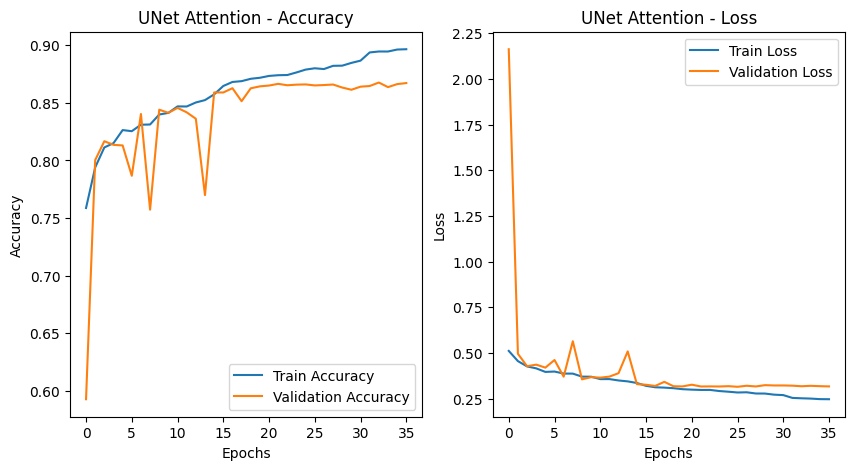

In [40]:
plot_training_history(unet_att_history, "UNet Attention")

In [41]:
unet_att.save("unet_att.keras")

In [42]:
with open('/kaggle/working/training_unet_att_history.pkl', 'wb') as file:
    pickle.dump(unet_att_history.history, file)

In [33]:
#!mv unet_att.keras /kaggle/working/

mv: 'unet_att.keras' and '/kaggle/working/unet_att.keras' are the same file


In [43]:
unet_att_trained_model = load_model("/kaggle/working/unet_att.keras")

In [44]:
unet_att_trained_history = trained_history('/kaggle/working/training_unet_att_history.pkl',unet_att_trained_model, ['U-Net (Training)', 'U-Net (Validation)'], X_train, y_train, X_test, y_test)
print(unet_att_trained_history)

71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step
            Algorithm  Accuracy     Loss       IOU
0    U-Net (Training)  0.896627  0.24670  0.713390
1  U-Net (Validation)  0.867236  0.31688  0.670257


In [45]:
unet_att_masks = unet_att.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step


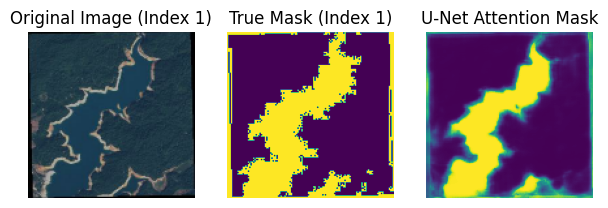

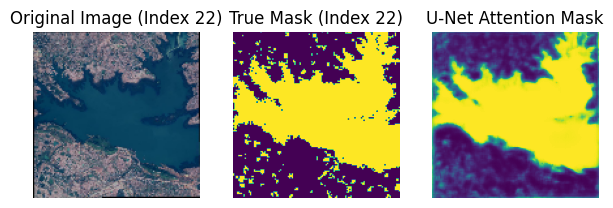

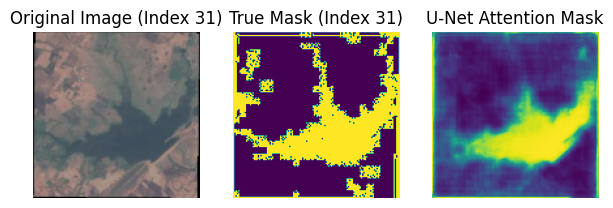

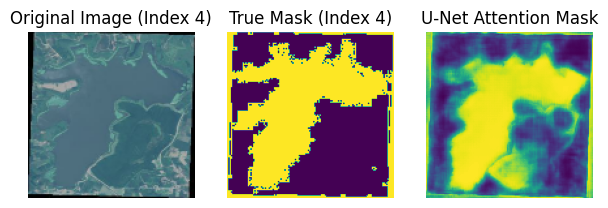

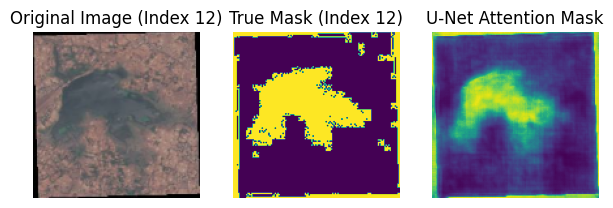

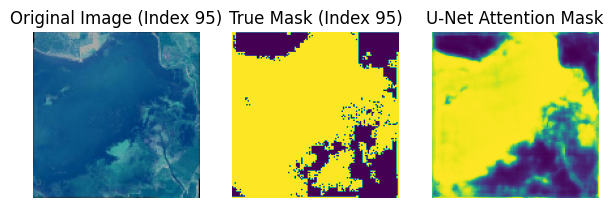

In [46]:
plot_images(X_test, y_test,unet_att_masks, selected_indices = [1, 22, 31, 4, 12, 95])